# **Hong Kong Instagram Username Classification**

This machine learning project aims to discover the feasibility of classifying Hong Kong Instagram users solely based on the usernames. 

Sklearn's Logistic Regression, Random Forest and SVM are chosen as the baseline models for this binary classification project.<br>
Results would be either "True" for HK users or "False" for non-HK users. 

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import SyllableTokenizer

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

SEED = 42 # set the random seed to 42 for reproducibility

## 1. Data Collection

The data is scraped from [HypeAuditor](https://hypeauditor.com/) using my own web scraper (**hypeauditor_scraper.py**). You may either use the pre-scraped datasets stored in the "datasets" file or manually scrape the data by following the instructions below.

To Use the Scraper: 
1. Download the required libraries and chrome driver by following the instructions in [Eslite Scraper](https://github.com/kuntiniong/Eslite-Scraper)
2. Uncomment code block [2]&[3] and comment out [4]
3. Delete "datasets" file
4. Register an account on [HypeAuditor](https://hypeauditor.com/) using gmail
5. Execute the code

*Note: By the context of HK and non-HK usernames, it is referring to the top 1000 most popular Instagram users in Hong Kong and India on [HypeAuditor](https://hypeauditor.com/)*

In [2]:
# from hypeauditor_scraper import HypeAuditorScraper

# gmail = "<your gmail>"
# password = "<password>"

# scraper = HypeAuditorScraper()
# hongkong_username_df = scraper.scrape(gmail, password, hongkong = True)
# non_hongkong_username_df = scraper.scrape(gmail, password, hongkong = False)

In [3]:
# datasets_folder_path = os.path.join(os.getcwd(), 'datasets')
# os.makedirs(datasets_folder_path)
# os.chdir(datasets_folder_path)
# hongkong_username_df.to_csv("hongkong_username.csv")
# non_hongkong_username_df.to_csv("non_hongkong_username.csv")

## 2. Data Preprocessing

### 2.1 Merging Datasets and Labelling

Merge the two datasets **hongkong_username.csv** and **non_hongkong_username.csv** into a dataframe and label HK users as True and non-HK users as False. 

In [4]:
# comment out this block if you wish to use the scraper
datasets_folder_path = os.path.join(os.getcwd(), 'datasets') 
os.chdir(datasets_folder_path)

In [5]:
hongkong_username_df = pd.read_csv("hongkong_username.csv")
hongkong_username_df["Hong Kong"] = True
non_hongkong_username_df = pd.read_csv("non_hongkong_username.csv")
non_hongkong_username_df["Hong Kong"] = False

df = pd.concat([hongkong_username_df, non_hongkong_username_df], axis = 0, ignore_index = True)
df = df.drop(df.columns[0], axis = 1)
df

,IG Username,Hong Kong
0,gem0816,True
1,derek_tch,True
2,kelly.fuu,True
3,ansonlht,True
4,keung_show,True
...,...,...
1995,official_mayaali,False
1996,r_rajesh_07,False
1997,rterdogan,False
1998,surbhijyoti,False


### 2.2 Data Cleaning

Drop duplicated entries to prevent skewed distribution.

In [6]:
original_size = len(df['IG Username'])
df = df.drop_duplicates(subset=['IG Username']) 
new_size1 = len(df['IG Username'])
print(f'{original_size - new_size1} duplicated entries are removed, {new_size1} entries are retained.')

127 duplicated entries are removed, 1873 entries are retained.


Since numbers and punctuations do not contain userful information in classifying, RegEx is used to remove them. <br> Then, drop empty entries because some usernames may only contain numbers and punctuations.


For example:
```
"r_rajesh_07" -> "rrajesh"
"433" -> ""
```

In [7]:
df["IG Username"] = df["IG Username"].apply(lambda x: re.sub(r'[\d._]+', '', x)) 
df = df[df['IG Username'] != ""] 
new_size2 = len(df['IG Username'])
print(f'{new_size1 - new_size2} empty entries are removed, {new_size2} entries are retained.')

1 empty entries are removed, 1872 entries are retained.


### 2.3 Tokenization

Here are 4 reasons to tokenize usernames based on syllables:

1. **No whitespaces between words** 
    * Lack of whitespaces in the Instagram usernames makes the traditional tokenizers that heavily rely on whitespaces cannot work properly.

2. **Usernames are not sentences**
    * In other words, usernames are too short to extract a "word" as a unit for the features.

3. **Usernames are not proper English**
    * Usernames are not proper English vocabularies, any conventional tokenizers will not have the word embeddings for usernames, so a subword tokenizer that tokenizes a word based on the prefixes and suffixes would also not work.

4. **No Cantonese-specific tokenizer**
    * The crucial reason to use syllable tokenizer is the absence of a pretrained Romanized Cantonese tokenizer. Syllable tokenization can provide a workaround by capturing some linguistic structure of Cantonese based on the behavior of the NLTK tokenizer, albeit the lack of Cantonese word embeddings. (more details in *3.4*)        

Using NLTK syllable tokenizer to tokenize the usernames.


In [8]:
tokenizer_model = SyllableTokenizer()
df["Tokenized IG Username"] = df["IG Username"].apply(lambda x: np.array(tokenizer_model.tokenize(x))) 
df["Tokenized IG Username"]
df

,IG Username,Hong Kong,Tokenized IG Username
0,gem,True,[gem]
1,derektch,True,"[de, rektch]"
2,kellyfuu,True,"[kel, ly, fuu]"
3,ansonlht,True,"[an, sonlht]"
4,keungshow,True,"[keungs, how]"
...,...,...,...
1995,officialmayaali,False,"[of, fi, cial, may, a, a, li]"
1996,rrajesh,False,"[rra, jesh]"
1997,rterdogan,False,"[rter, do, gan]"
1998,surbhijyoti,False,"[surb, hi, jyo, ti]"


### 2.4 Encoding

To convert categorical features (tokenized usernames) into binary data for easier model interpretation using one-hot encoding (OHE). 

In [9]:
unique_syllables = df["Tokenized IG Username"].explode().unique()
for i in unique_syllables:
  df[i] = df["Tokenized IG Username"].apply(lambda syllable_list: int(i in syllable_list))
X = df.iloc[:,3:]
X

,gem,de,rektch,kel,ly,fuu,an,sonlht,keungs,how,...,dwa,moor,shar,dult,goul,rra,jesh,rter,jyo,miks
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3. Data Exploration

### 3.1 Distribution of HK and non-HK Entries 

During data collection, the dataset is balanced as there are equally 1000 HK and 1000 non-HK entries. However, some of the entries are dropped after data cleaning. Therefore, the distribution of data needs to be checked again to avoid biased model performance.

In this case, HK comprises 49.4% and non-HK comprises 50.6% of the entries. So, further data processing is not required as it is still balanced enough.

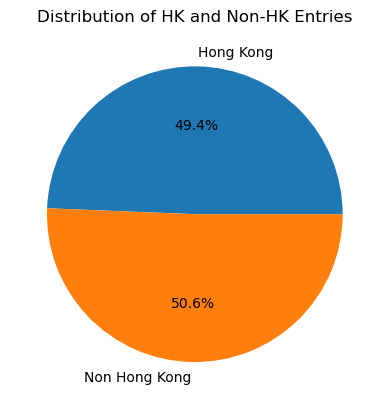

In [10]:
def getData(hk):
  return len(df.loc[(df['Hong Kong'] == hk), 'Hong Kong'])

plt.pie([getData(1), getData(0)], 
        labels = ['Hong Kong', 'Non Hong Kong'], autopct = '%1.1f%%')
plt.title("Distribution of HK and Non-HK Entries")
plt.show()

### 3.2 Distribution of Repeated and Unique Syllables

To give an overview of 4630 (65.6%) syllables are repeated and can be used as useful features in classifying. <br> This is because reapeated syllables can act as a pattern for the classifying model to **generalize** the usernames rather than to memorize the unique syllables.

There are 4630 repeated syllables and 2425 unique syllables.


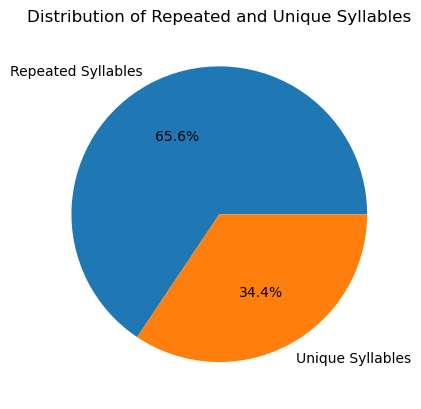

In [11]:
all_syllables = len(df["Tokenized IG Username"].explode())
unique_syllables = len(df["Tokenized IG Username"].explode().unique())
repeated_syllables = all_syllables - unique_syllables

print(f'There are {repeated_syllables} repeated syllables and {unique_syllables} unique syllables.')

plt.pie([repeated_syllables, unique_syllables], 
        labels = ['Repeated Syllables', 'Unique Syllables'], autopct = '%1.1f%%')
plt.title("Distribution of Repeated and Unique Syllables")

plt.show()

Next, the following pie charts are used to further investigate if the distribution of repeated and unique syllables in HK and Non-HK users. 

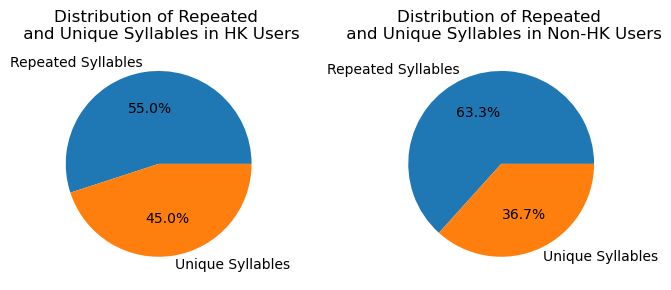

In [12]:
def getData(hk):
  return df.loc[~(df['Hong Kong'] == hk), 'Tokenized IG Username']

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

for i in range(2):
  total_syllables = len(getData(i).explode())
  unique_syllables = len(getData(i).explode().unique())
  repeated_syllables = total_syllables - unique_syllables

  title = "HK" if i == 0 else "Non-HK"
  ax[i].pie([repeated_syllables, unique_syllables], 
          labels = ['Repeated Syllables', 'Unique Syllables'], autopct = '%1.1f%%')
  ax[i].set_title(f"Distribution of Repeated \n and Unique Syllables in {title} Users")

plt.tight_layout()
plt.show()

From above, we can see that (55.0% repeated, 45% unique) for HK users and (63.3% repeated, 36.7% unique) for Non-HK users. <br> Overall, Non-HK users have a higher percentage of repeated syllables. *The classifying models might result in classifying the Non-HK usernames better as there are more repeated syllables available.*

To conclude, the percentage of repeated and unique syllables are quiet reasonable as there are multiple syllables in the username and the classifying model might fail to generalize the pattern of the username if there are too much repeated syllables.

### 3.3 Visualizing the Potential Patterns between Syllables using t-SNE

Used an unsupervised dimensionality reduction technique t-SNE (t-Distributed Stochastic Neighbor Embedding) to give an initial overview of the possible underlying patterns of syllables in the usernames. 

In this case, dim(2425) is reduced to dim(2).

In [13]:
X.shape

(1872, 2425)

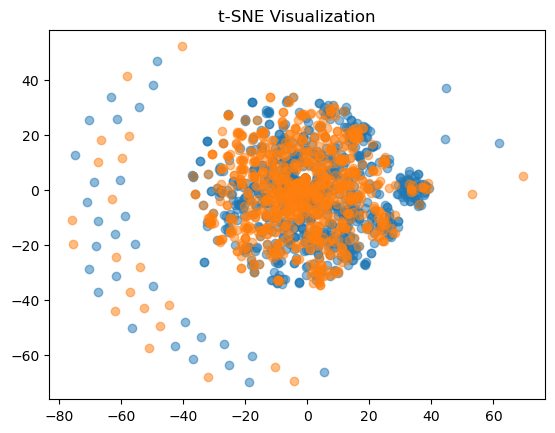

In [14]:
tsne = TSNE(n_components = 2, random_state = SEED)
X_tsne = tsne.fit_transform(X)

df_tsne = pd.DataFrame(data = X_tsne, columns = ['tsne_x', 'tsne_y'])
df_tsne["target"] = df['Hong Kong']

for i in range(2):
  color = ['tab:blue', 'tab:orange']
  plt.scatter(x = df_tsne.loc[(df_tsne['target'] == i), 'tsne_x'], 
              y = df_tsne.loc[(df_tsne['target'] == i), 'tsne_y'], 
              color = color[i], alpha = 0.5)

plt.title("t-SNE Visualization")
plt.show()

From the graph above, no useful insights can be observed as the scatters do not form any distinct clusters.

A possible factor to this might be each syllable in the usernames is treated independently (per column) but not the entire username (per row). <br> In addition, curse of dimensionality could also be the reason as reducing dimensionality from 2425 to just 2 can lose a lot of information considering the dataset is small and each feature might only have a few entries. Therefore, the resulting t-SNE plot may not reveal distinct clusters or patterns in the data.

### 3.4 Further Analysis on the Syllables using Linguistics

To highlight some of the interesing naming patterns and behavior of the syllable tokenizer of both HK and non-HK users.


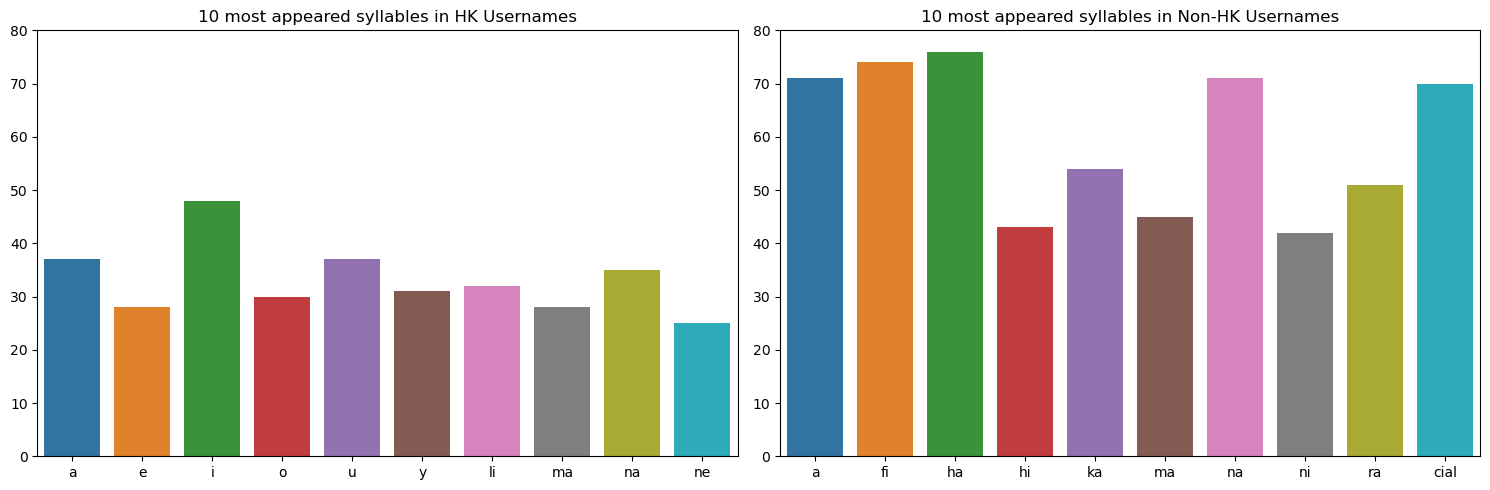

In [15]:
def getData(hk):
  return df.loc[~(df["Hong Kong"] == hk), "Tokenized IG Username"].explode().value_counts() # already descending

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
  top_ten_freq = getData(i).head(10).sort_index().sort_index(key = lambda x: x.str.len()) # sort alphabetically then sort by length
  x = top_ten_freq.index
  y = top_ten_freq.values

  title = "HK" if i == 0 else "Non-HK"
  sns.barplot(x = x, y = y, ax = ax[i])
  ax[i].set_title(f"10 most appeared syllables in {title} Usernames")
  ax[i].set_ylim(0, 80)

plt.tight_layout()
plt.show()

Terminologies:

* **Vowels**: a,e,i,o,u,y* and can be a standalone syllable
* **Consonants**: characters that are not vowels and cannot be a standalsone syllable
* **Consonant-vowel (CV) syllables**: a syllable that contain both vowel and consonants, e.g. 'fi', 'ha', etc.
* **Monosyllabic**: single/ one syllable

*Note: y sometimes can act as a vowel as well*

#### Explanation of the Results

  1. **Higher Appearance of standalone Vowels in HK** -> Unique Vowel Clusters
      * Romanized Cantonese has a lot of unique adjacent vowels compared to English or other languages
      * for example: {"張": "ch-***eu***-ng", "楊": "  ***yeu***-ng", "趙": "ch-***iu***", "游": "  ***yau***", ...}
      * the tokenizer is not familiar with these clusters and might treat them as an individual syllable

  2.  **Less CV syllables, more Unique Syllables in HK**-> Complex Consonants Clusters
      * Romanized Cantonese also has a lot of complex consonants combinations and some can even contain no vowels at all.
      * for example : {"翠": "***ts***-ui", "芷": "  ***tsz***", "吳": "***ng***", "郭": "***kw***-ok", ...}
      * This confuses the tokenizer to group the consonants to other vowels, resulting in more unique syllables

  3. **Lower Frequency of a syllable in HK** -> Monosyllabic Chinese Characters
      * the maximum frequency of a syllable is around 75 ("ha") in Non-HK while it is only roughly 50 ("i") in HK 
      * Hong Kong People's name are mostly made up of 3 Chinese characters, and each chinese character only has one syllable
      * i.e. Hong Kong People's name at most have 3 syllables and leads to overall lower frequency of syllables in usernames

However, it is crucial to understand that usernames are a complicated subject and do not only contain user's actual name. For instance, the high presence of the "**-cial**" syllable in non-HK usernames is an evidence of individuals incorporating elements other than their name, such as the word "official," into their usernames.

## 4. Data Splitting

To split the **feature matrix** (X) and **target vector** (y) into training dataset (**80%**) and testing dataset (**20%**). <br>
Splitting into two sets can avoid overfitting because the model may become too specific to the unsplitted training data and fails to generalize well to new data.

In [16]:
X = df.iloc[:,3:]
y = df["Hong Kong"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED)

In [17]:
# check size
data_name_list = ["X_train", "y_train", "X_test", "y_test"]
arr = [X_train, y_train, X_test, y_test]
for i in range(4):
  print(f"Size of {data_name_list[i]}: {arr[i].shape}")

Size of X_train: (1497, 2425)
Size of y_train: (1497,)
Size of X_test: (375, 2425)
Size of y_test: (375,)


Again, check the distribution of the splitted dataset to avoid skewing. <br> The following graphs show that both training data and testing data are balanced, which are 49.3% HK, 50.6% Non-Hk and 49.3% HK, 50.7% Non-HK respectively.

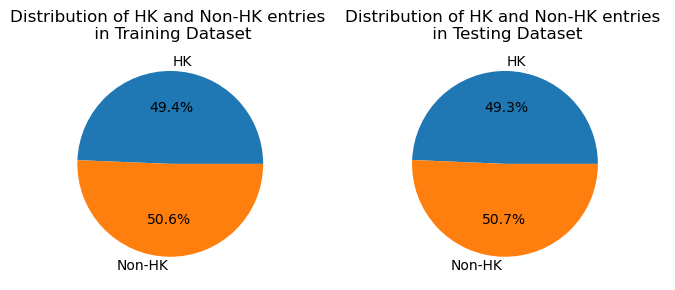

In [18]:
def getData(train, hk):
  return len(y_train[y_train == hk]) if train == 0 else len(y_test[y_test == hk]) 

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

for i in range(2): 
    title = ['Training Dataset', 'Testing Dataset']
    ax[i].pie([getData(i,1), getData(i,0)], labels = ['HK', 'Non-HK'], autopct='%1.1f%%')
    ax[i].set_title(f"Distribution of HK and Non-HK entries \n in {title[i]}")

plt.tight_layout()
plt.show()


## 5. Hyperparameter Tuning

### 5.1 Choosing Models for Hyperparameter Tuning

#### Brief explanation of how the three chosen models work: 

1. **Logistic Regression (LR)** 
    * assume the data follows a Bernoulli distribution (0 or 1)
    * maximizes the likelihood of the data with gradient descent  
    * calculate the probability with the logistic function 

2. **Random Forest (RF)**
    * two types of node in a binary decision tree: 
        * conditional node (set conditions and branch one more pair of condtional and leaf nodes) 
        * leaf node (predicted values/ data that satisfy all the conditions)
    * maximizes the separation of classes by choosing one of the many decision trees (ensemble)
    * create mulitple trees because the conditions set at the root node are arbitrary and can vastly affect the results 
     
3. **Supported Vector Machines (SVM)**
    * treat the data as vectors in a vector space that is higher than original dimensionality of the data (kernal trick)
    * maximizes the margin between classes by finding the optimal hyperplane

#### Visualization of the Decision Boundaries

Though this visualization only gives a partial overview of the decision boundaries, as ```X_test``` is being reduced to 2D with Principal Component Analysis (PCA), it is good enough to show a general idea of how the decision boundaries are formed by different models.

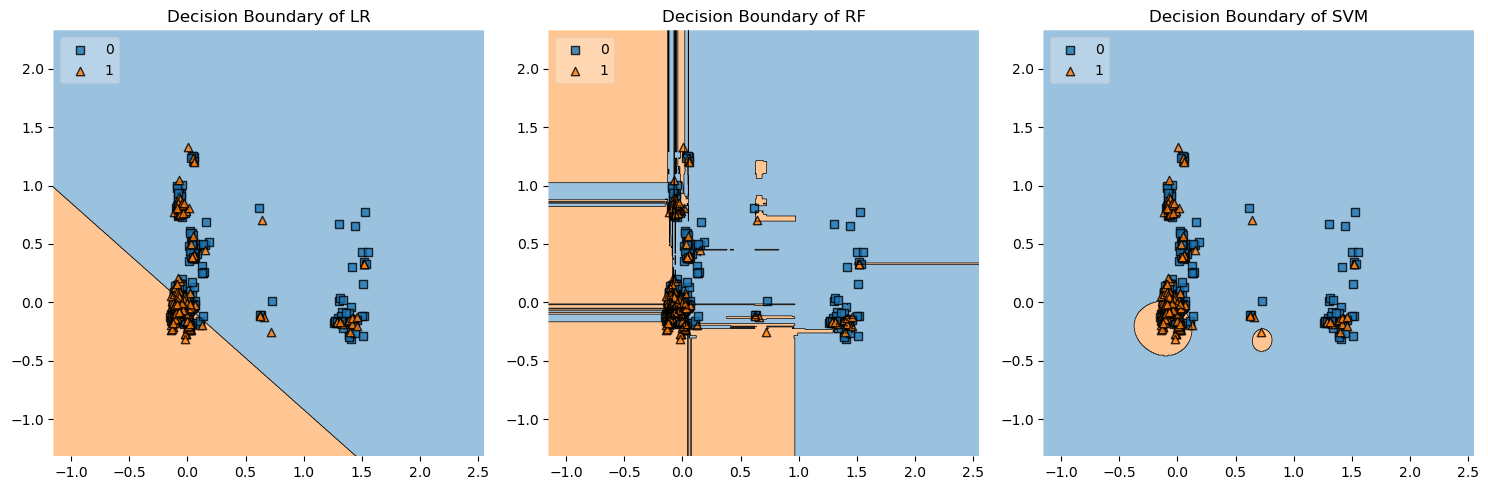

In [19]:
def visualize(X_train, y_train):
  
  models = [('LR', LogisticRegression()),
            ('RF', RandomForestClassifier(random_state=SEED)),
            ('SVM', SVC())]

  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  pca = PCA(n_components = 2)
  re_X_train = pca.fit_transform(X_train)
 
  for i in range(3):    
    clf = models[i][1]
    clf.fit(re_X_train, y_train)
    plot_decision_regions(X = re_X_train, y = y_train.to_numpy().astype(int), clf = clf, legend = 2, ax = ax[i])
    
    name = models[i][0]
    ax[i].set_title(f'Decision Boundary of {name}')

  plt.tight_layout()
  plt.show()

visualize(X_train, y_train)

##### Explanation of the Visualization:

1. **Logistic Regression (LR)** 
    * the division boundary is linear 
    * might not be able to capture non-linear relationships

2. **Random Forest (RF)**
    * the division boundary is non-linear 
    * be able to capture very complex non-linear relationships 
    * could be a double-edged sword as it can easily underfit or overfit 
     
3. **Supported Vector Machines (SVM)**
    * the division boundary is non-linear
    * be able to capture non-linear relationships
    * effective in handling high-dimensional features
    * very sensitive to the choice of kernel and its hyperparameters

Overall, SVM has the potential to be the best choice if all the hyperparameters are properly tuned, but since the dataset is small, it is still essential to evaluate and compare the performance of all the models on this specific dataset. By tuning and deploying all three models, we can determine which one yields the best results and is most suitable for the given task.

### 5.2 Hyperparameter Tuning

An exhaustive search method in Sklearn ```GridSearchCV()``` that combines grid search and k-fold validation is used to tune the hyperparameters. <br> During this process, hyperparameter tuning, model training and 5-fold validation are performed simultaneously. 

All the testing hyperparameters are listed in the parameter grid ```param_grid``` and are determined based on accuracy.

#### Brief explanations on the choice of testing hyperparameters:

Since the dataset is small, contains a lot of features (2425 syllables), and each feature may only have a few entries, the model might have a higher tendency to memorize the limited samples in the training data set and fail to generalize on unseen data. 

So the main priority here for tuning the hyperparameters would be to prevent overfitting. Common approaches would be regularizing the data in LR, determining the levells of conditions ran through in RF and find the optimal margin in SVM.

In [20]:
def hpTuning(X_train, y_train):

  clf = [LogisticRegression(), RandomForestClassifier(random_state = SEED), SVC()] # three different classification models
  param_grid = [{
    'solver': ['liblinear'], # good for small datasets and binary classification; support l1 and l2 regularization
    'penalty': ['l1', 'l2'], # 2 different regularization method to prevent overfitting by adding a penalty term
    'C': [1, 10, 20] # regularization strength; smaller c greater regularization strength 
  },{
    'n_estimators': [100, 150], # number of trees in the 'forest'
    'max_depth': [3, 5, 7] # the data run through how many levels of conditions
  },{
    'C': [1, 10, 20], # smaller c greater margin
    'gamma': ['auto', 'scale'] # 1 / (n_features * X.var()), 1 / n_features
  }]

  best_clf = []
  
  for i in tqdm(range(3)):
    grid_search = GridSearchCV(estimator = clf[i], 
                               param_grid = param_grid[i], 
                               cv = 5,
                               scoring = 'accuracy', 
                               n_jobs = -1) # -1 to enable parallel processing
    
    grid_search.fit(X_train, y_train) # train
    best_clf.append((grid_search.best_estimator_, 
                     grid_search.best_score_))   

  return best_clf

best_clf = hpTuning(X_train, y_train)
results = pd.DataFrame(data = best_clf, 
                       index = ['LR', 'RF', 'SVM'],
                       columns = ["Hyperparameters", "Accuracy"])

pd.set_option('display.max_colwidth', None)
results

100%|██████████| 3/3 [00:49<00:00, 16.33s/it]


Hyperparameters  \
LR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Tuning Results:

1. **Logistic Regression (LR)**
    * hyperparameter ```C``` is 1, which is relatively small and the regularization strength is strong
    * it is not overfitting and has second best accuracy with **0.680702**

2. **Random Forest (RF)**
    * hyperparameter ```max_depth``` is 5, which indicates a moderately shallow tree and have limited number of conditions
    * however, it has the worst accuracy with **0.649984**, so it might suggest that RF is underfitting

3. **Support Vector Machines (SVM)**
    * hyperparameter ```C``` is 1, which is relatively small and the margin between the support vectors is large.
    * it is not overfitting and has best accuracy with **0.686049**  

As expected, SVM has the best performance while RF has the worst performance due to potential underfitting or overfiting. Nevertheless, the performance of LR is also noteworthy. Despite its linear division boundaries and potential limitations in capturing complex non-linear relationships, LR has shown competitive performance on the dataset.

## 6. Model Testing 

### 6.1 Confusion Matrix

To visualize the testing performance of each model in a confusion matrix.

|             | Predicted Negative | Predicted Positive |
|-------------|-------------------|-------------------|
| Actual Negative |       True Negative (TN)          |       False Positive (FP)        |
| Actual Positive |       False Negative (FN)          |       True Positive (TP)         |

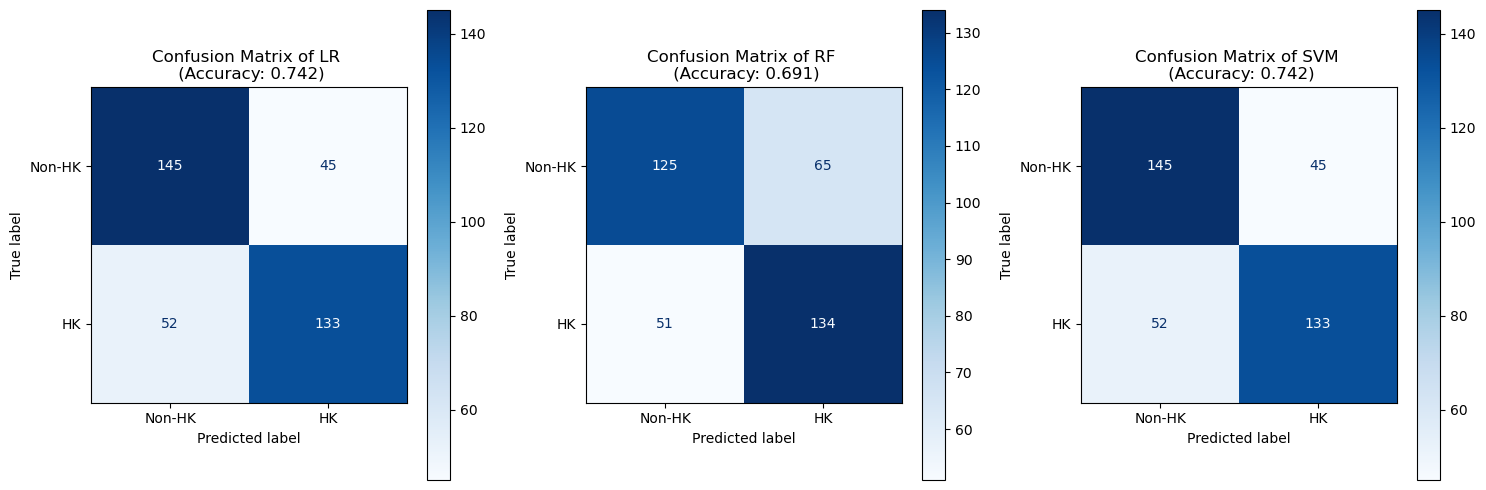

In [21]:
def performance_test(best_clf, X_test, y_test):
  
  model_name = ['LR', 'RF', 'SVM']
  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  for i in range(3):
    y_pred = best_clf[i][0].fit(X_train, y_train).predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
 
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-HK', 'HK'])
    disp.plot(cmap = 'Blues', ax = ax[i])

    accuracy = math.ceil(accuracy_score(y_test, y_pred)*1000)/1000 # round to 3 dp
    ax[i].set_title(f'Confusion Matrix of {model_name[i]} \n (Accuracy: {accuracy})')

  plt.tight_layout()
  plt.show()

performance_test(best_clf, X_test, y_test)

#### Explanation of the results:

Testing results have significantly better performance than validation results while RF is still the model with the worst performance (0.691).

Surprisingly, both LR and SVM have identical results, achieving 0.742 accuracy, 133 TP, and 145 TN. <br> Moreover, with number of TN > TP, this also proves the hypothesis stated in *3.2*, 'The classifying models might result in classifying the Non-HK usernames better as there are more repeated syllables available.' is correct.

### 6.2 Classification Report

Showing other evaluation metrics like precision, recall, etc. in a tabular form.

In [22]:
# classification report
model_name = ['LR', 'RF', 'SVM']
for i in range(3):
  y_pred = best_clf[i][0].fit(X_train, y_train).predict(X_test)
  print(f'Classification Report of {model_name[i]}')
  print(classification_report(y_test, y_pred))

Classification Report of LR
              precision    recall  f1-score   support

       False       0.74      0.76      0.75       190
        True       0.75      0.72      0.73       185

    accuracy                           0.74       375
   macro avg       0.74      0.74      0.74       375
weighted avg       0.74      0.74      0.74       375

Classification Report of RF
              precision    recall  f1-score   support

       False       0.71      0.66      0.68       190
        True       0.67      0.72      0.70       185

    accuracy                           0.69       375
   macro avg       0.69      0.69      0.69       375
weighted avg       0.69      0.69      0.69       375

Classification Report of SVM
              precision    recall  f1-score   support

       False       0.74      0.76      0.75       190
        True       0.75      0.72      0.73       185

    accuracy                           0.74       375
   macro avg       0.74      0.74      0.74

Once again, by checking the f1-score (the harmonic mean of precision and recall) of LR or SVM, the f1-score of false (0.75) is slightly better than true (0.73). Both models are better at identifying Non-HK usernames than HK usernames. And all the metrics in RF are worse than RF or SVM.

## 7. Evaluation and Conclusion

### 7.1 Model Selection

To wrap up, I would choose **SVM** over LR for actual deployment due to its **scalability**. Even though they show a similar performance, as the dataset grows larger, LR may face challenges in capturing non-linear relationships of the syllables effectively. On the other hand, SVM is capable of handling non-linear relationships and can scale well to accommodate larger datasets with well-tuned hyperparameters and the kernel trick. However, if simplicity and computational cost are the main concerns, LR might be a more suitable choice to work with a small dataset. 

### 7.2 Limitations 

Due to ethics and Instagram's API policies, the size and quality of the collected usernames are restricted. This can vastly affect the model's performance and here are some limitations to the classification model due to the quality of training datasets:

1. **Public Accounts**
    * The dataset consists of the top 1000 most popular accounts in each country/region, which primarily include celebrities and influencers. These individuals are more likely to include their actual names in their usernames for recognition purposes. In contrast, regular users may prioritize privacy and may not include their real names in their usernames. This discrepancy can affect the model's performance, as it relies on the assumption that usernames contain unique Romanized Cantonese syllables. 


2. **English Names of HK Users**
    * Due to historical reasons, many HK people have adopted English names, which they may include in their usernames. This poses a challenge for the syllable-based classification, as the uniqueness of Romanized Cantonese syllables is lost when English names are present. In this particular classification, Indian names were used as the non-HK dataset because they generally have more syllables, making them easier to distinguish. Therefore, the model's performance may not be as effective when applied to usernames from other English-speaking countries, such as the US or the UK. Nonetheless, it is not entirely impossible for the model to identify the unique English names preferred by HK users, such as "Candy" or "Apple", especially with a larger dataset.

3. **Variability in Romanized Chinese**
    * Besides Cantonese, there are other Chinese dialects and languages, such as Mandarin, that have their own Romanization systems. The variability in Romanized Chinese presents a challenge in accurately identifying and classifying usernames written in these different systems. This further adds to the complexity of the classification task.

### 7.3 Improvement

To further enhance the performance of this model, the following several strategies can be implemented:

1. **Larger Dataset** 
    * provide more diverse examples
    * contains usernames from more different countries/ regions

2. **Cantonese-specific Tokenizer**
    * custom Romanized Cantonese embeddings
    * to tokenize the usernames more accurately and consistently
  
3. **Additional Information**
    * incorporating with users' Instagram bio 
    * bio can contain Cantonese characters, and if so, it will be more likely to be a HK user

### 7.4 Conclusion

In summary, this project demonstrates the classification of Hong Kong Instagram usernames, in which the **SVM** model is achieving a **74.2% accuracy**, using an unconventional tokenization technique based on syllables. The core principle of this classification task revolves around the behavior of the NLTK syllable tokenizer and the distinctive linguistic features of Romanized Cantonese.

Nevertheless, identifying usernames is a challenging topic and it is still important to acknowledge the limitations of this classification approach, such as the presence of public accounts, the inclusion of English names in HK users' usernames, and the variability in Romanized Chinese. Moreover, to enhance the model's performance, consider expanding the dataset, developing a Cantonese-specific tokenizer, and incorporating users' Instagram bios for improved classification results. 